# Classification problem on the Twenty News Groups dataset

In this exercise, we'll use the [tf-idf representation](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) to create feature vectors of the emails in the <i>twenty newsgroups</i> dataset and build a classifier to identify emails belonging to <i>computer related topics</i> and those which aren't.

More information on the <i>Twenty Newsgroups</i> dataset can be found on the [UCI website](http://kdd.ics.uci.edu/databases/20newsgroups/20newsgroups.html)

## Setup database connectivity

We'll reuse our module from the previous notebook (***`00_database_connectivity_setup.ipynb`***) to establish connectivity to the database

In [1]:
%run '00_database_connectivity_setup.ipynb'
%matplotlib inline
from IPython.display import display

Your connection object is ***`conn`***:
1. Queries: You can run your queries using ***```psql.read_sql("""<YOUR SQL>""", conn)```***.
2. Create/Delete/Updates: You can run these statements using ***```psql.execute("""<YOUR SQL>""", conn)```***, followed by a ***```conn.commit()```*** command to ensure your transaction is committed. Otherwise your changes will be rolledback if you terminate your kernel.

If you created a new connection object (say to connect to a new cluster) as shown in the last section of `00_database_connectivity_setup.ipynb` notebook, use that connection object where needed.

## 1. Create your schema

In [ ]:
sql = """
    create schema YOUR_SCHEMA;
"""
psql.execute(sql, conn)
conn.commit()

## 2. Load the Twenty News Groups dataset into a database table

In [12]:
sql = """
    -- Define external table to fetch data from HDFS
    drop external table if exists YOUR_SCHEMA.twenty_news_groups_ext cascade;
    create external table YOUR_SCHEMA.twenty_news_groups_ext
    (
        doc_id int,
        contents text,
        label text
    ) location ('pxf://hdm1.gphd.local:50070/user/vatsan/dstraining/twenty_news_groups_processed.tsv?profile=hdfstextsimple') 
    format 'CSV' (DELIMITER = E'\t');

    -- create an internal table
    drop table if exists YOUR_SCHEMA.twenty_news_groups cascade;
    create table YOUR_SCHEMA.twenty_news_groups
    as
    (
        select 
            *
        from
            YOUR_SCHEMA.twenty_news_groups_ext
    ) distributed randomly;
"""
psql.execute(sql, conn)
conn.commit()

In [13]:
sql = """
    select 
        *
    from
       YOUR_SCHEMA.twenty_news_groups
    order by random()
    limit 10
"""
df = psql.read_sql(sql, conn)
df.head()

,doc_id,contents,label
0,7491,From: russotto@eng.umd.edu (Matthew T. Russott...,talk.religion.misc
1,4118,From: wihervaa@messi.uku.fi (Mikko Wihervaara)...,rec.sport.hockey
2,5405,From: chungdan@leland.Stanford.EDU (Zhong Qi I...,sci.med
3,12635,From: mbeaving@bnr.ca (Michael Beavington)\nSu...,rec.motorcycles
4,17799,"From: casper@vxcrna.cern.ch (CASPER,DAVI./PPE)...",talk.politics.mideast


## 3. Tokenize the documents and create an inverted index

In [3]:
sql = """
    --1) Create an inverted index, compute term frequencies
    drop table if exists twenty_news_groups_term_frequencies cascade;
    create temp table twenty_news_groups_term_frequencies
    as
    (
        select
            token,
            doc_id,
            count(*) as tf
        from
        (
            select
                doc_id,
                regexp_split_to_table(
                    --convert to lower case
                    --replace newlines/carriage returns to space
                    regexp_replace(lower(contents), E'\\r|\\n', ' ', 'g'), 
                    E'\\\s+'
                ) as token
            from
                YOUR_SCHEMA.twenty_news_groups
        )q
        group by token, doc_id    
    ) distributed randomly;
    
    --2) Compute tf-idf scores.
    drop table if exists YOUR_SCHEMA.twenty_news_groups_tf_idf cascade;
    create table YOUR_SCHEMA.twenty_news_groups_tf_idf
    as
    (
        select
            t1.token,
            t1.doc_id,
            t1.tf,
            t2.df,
            tf*log(t3.num_docs*1.0/df) as tf_idf
        from
            twenty_news_groups_term_frequencies t1,
            (
                select
                    token,
                    count(distinct doc_id) as df
                from 
                    twenty_news_groups_term_frequencies
                group by token
            ) t2,
            (
                select
                    count(distinct doc_id) as num_docs
                from
                    twenty_news_groups_term_frequencies
            ) t3
        where t1.token = t2.token
    ) distributed randomly;
 
    --3) Remove stop words and filter out tokens which don't occur in atleast 2% of the documents
    -- This defines our vocabulary
    drop table if exists YOUR_SCHEMA.twenty_news_groups_vocabulary cascade;
    create table YOUR_SCHEMA.twenty_news_groups_vocabulary
    as
    (
        select
            token
        from
        (
            select
                token,
                count(distinct doc_id) as num_docs
            from
                YOUR_SCHEMA.twenty_news_groups_tf_idf
            where
                -- Remove stopwords
                token not in (
                    'a\\'s','able','about','above','according','accordingly','across','actually','after','afterwards','again','against','ain\\'t',
                    'all','allow','allows','almost','alone','along','already','also','although','always','am','among','amongst','an','and',
                    'another','any','anybody','anyhow','anyone','anything','anyway','anyways','anywhere','apart','appear','appreciate',
                    'appropriate','are','aren\\'t','around','as','aside','ask','asking','associated','at','available','away','awfully',
                    'be','became','because','become','becomes','becoming','been','before','beforehand','behind','being','believe','below',
                    'beside','besides','best','better','between','beyond','both','brief','but','by','c\\'mon','c\\'s','came','can','can\\'t',
                    'cannot','cant','cause','causes','certain','certainly','changes','clearly','co','com','come','comes','concerning','consequently',
                    'consider','considering','contain','containing','contains','corresponding','could','couldn\\'t','course','currently','definitely',
                    'described','despite','did','didn\\'t','different','do','does','doesn\\'t','doing','don\\'t','done','down','downwards','during',
                    'each','edu','eg','eight','either','else','elsewhere','enough','entirely','especially','et','etc','even','ever','every',
                    'everybody','everyone','everything','everywhere','ex','exactly','example','except','far','few','fifth','first','five',
                    'followed','following','follows','for','former','formerly','forth','four','from','further','furthermore','get','gets',
                    'getting','given','gives','go','goes','going','gone','got','gotten','greetings','had','hadn\\'t','happens','hardly','has',
                    'hasn\\'t','have','haven\\'t','having','he','he\\'s','hello','help','hence','her','here','here\\'s','hereafter','hereby','herein',
                    'hereupon','hers','herself','hi','him','himself','his','hither','hopefully','how','howbeit','however','i\\'d','i\\'ll','i\\'m',
                    'i\\'ve','ie','if','ignored','immediate','in','inasmuch','inc','indeed','indicate','indicated','indicates','inner','insofar',
                    'instead','into','inward','is','isn\\'t','it','it\\'d','it\\'ll','it\\'s','its','itself','just','keep','keeps','kept','know','knows',
                    'known','last','lately','later','latter','latterly','least','less','lest','let','let\\'s','like','liked','likely','little','look',
                    'looking','looks','ltd','mainly','many','may','maybe','me','mean','meanwhile','merely','might','more','moreover','most','mostly',
                    'much','must','my','myself','name','namely','nd','near','nearly','necessary','need','needs','neither','never','nevertheless','new',
                    'next','nine','no','nobody','non','none','noone','nor','normally','not','nothing','novel','now','nowhere','obviously','of','off',
                    'often','oh','ok','okay','old','on','once','one','ones','only','onto','or','other','others','otherwise','ought','our','ours',
                    'ourselves','out','outside','over','overall','own','particular','particularly','per','perhaps','placed','please','plus','possible',
                    'presumably','probably','provides','que','quite','qv','rather','rd','re','really','reasonably','regarding','regardless','regards',
                    'relatively','respectively','right','said','same','saw','say','saying','says','second','secondly','see','seeing','seem','seemed',
                    'seeming','seems','seen','self','selves','sensible','sent','serious','seriously','seven','several','shall','she','should',
                    'shouldn\\'t','since','six','so','some','somebody','somehow','someone','something','sometime','sometimes','somewhat','somewhere',
                    'soon','sorry','specified','specify','specifying','still','sub','such','sup','sure','t\\'s','take','taken','tell','tends','th',
                    'than','thank','thanks','thanx','that','that\\'s','thats','the','their','theirs','them','themselves','then','thence','there',
                    'there\\'s','thereafter','thereby','therefore','therein','theres','thereupon','these','they','they\\'d','they\\'ll','they\\'re',
                    'they\\'ve','think','third','this','thorough','thoroughly','those','though','three','through','throughout','thru','thus','to',
                    'together','too','took','toward','towards','tried','tries','truly','try','trying','twice','two','un','under','unfortunately',
                    'unless','unlikely','until','unto','up','upon','us','use','used','useful','uses','using','usually','value','various','very',
                    'via','viz','vs','want','wants','was','wasn\\'t','way','we','we\\'d','we\\'ll','we\\'re','we\\'ve','welcome','well','went','were',
                    'weren\\'t','what','what\\'s','whatever','when','whence','whenever','where','where\\'s','whereafter','whereas','whereby','wherein',
                    'whereupon','wherever','whether','which','while','whither','who','who\\'s','whoever','whole','whom','whose','why','will',
                    'willing','wish','with','within','without','won\\'t','wonder','would','would','wouldn\\'t','yes','yet','you','you\\'d','you\\'ll',
                    'you\\'re','you\\'ve','your','yours','yourself','yourselves','zero'
                )
            group by token
        )t1,
        (
            select
                count(distinct doc_id) as corpus_size
            from
                YOUR_SCHEMA.twenty_news_groups_tf_idf
        ) t2
        where 
            -- Only consider those tokens which have occurred in atleast 2% of the documents
            t1.num_docs >= 0.02*(t2.corpus_size)
    ) distributed randomly;
"""
psql.execute(sql, conn)
conn.commit()

In [15]:
#Print the vocabulary size
sql = """
    select
        count(*) as vocabulary_size
    from
        YOUR_SCHEMA.twenty_news_groups_vocabulary
"""
df = psql.read_sql(sql, conn)
vocabulary_size = df['vocabulary_size'][0]
display(df)
display(psql.read_sql("select * from YOUR_SCHEMA.twenty_news_groups_vocabulary limit 10", conn))
conn.commit()

,vocabulary_size
0,634


,token
0,.
1,so.
2,hardware
3,tin
4,reply
5,10
6,a
7,wait
8,subject:
9,past


## 4. Create a bag of words model with tf-idf as the features

In [8]:
#UDF to compute term-frequency vector
sql = """
    drop function if exists YOUR_SCHEMA.tf_idf_vectorize(float8[], text[], text[]);
    create or replace function YOUR_SCHEMA.tf_idf_vectorize(
        tf_idf_arr float8[],
        tokens_arr text[],
        vocabulary_arr text[]
    )
    returns float8[]
    as
    $$
        result = [0 for _ in xrange(len(vocabulary_arr))]
        idx_map = dict(map(lambda pr: reversed(pr), enumerate(vocabulary_arr)))
        tf_idf_dict = dict(zip(tokens_arr, tf_idf_arr))
        for key in tf_idf_dict.keys():
            if idx_map.has_key(key):
                result[idx_map[key]] = tf_idf_dict[key]
        return result
    $$language plpythonu;
"""
psql.execute(sql, conn)
conn.commit()

In [9]:
sql = """
    drop table if exists YOUR_SCHEMA.twenty_news_groups_bow_tf_idf cascade;
    create table YOUR_SCHEMA.twenty_news_groups_bow_tf_idf
    as
    (
        select
            doc_id,
            YOUR_SCHEMA.tf_idf_vectorize(
                tf_idf_arr,
                token_arr,
                vocab_arr
            ) as feature_vector
        from
            (
                select
                    doc_id,
                    array_agg(tf_idf order by token) as tf_idf_arr,
                    array_agg(token order by token) as token_arr
                from
                    YOUR_SCHEMA.twenty_news_groups_tf_idf
                group by doc_id
            )t1,
            (
                select
                    array_agg(token order by token) as vocab_arr
                from 
                    YOUR_SCHEMA.twenty_news_groups_vocabulary
            )t2
    ) distributed randomly;
"""
psql.execute(sql, conn)
conn.commit()

## 5. Create train & test split    

In [10]:
sql = """
    -- Set the seed to ensure the random splits are repeatable
    -- This is important if you want to measure performance 
    -- of classifiers based by varying the "num_bits" parameter
    -- Note: You should run the setseed() statement and the following create temp table statement as a single
    -- transaction.
    select setseed(0.5);
    drop table if exists bow_tf_idf_vector_train_test_split cascade;
    create temp table bow_tf_idf_vector_train_test_split
    as
    (
        select
            t1.doc_id,
            t1.feature_vector,
            -- to create a binary classification problem
            -- consider the task as being able to predict if a document is related to computers or not            
            case 
                when t2.label ~* 'comp.*' then 1 
                else 0
            end as label,
            random() as splitter
        from
            YOUR_SCHEMA.twenty_news_groups_bow_tf_idf t1,
            YOUR_SCHEMA.twenty_news_groups t2
        where
            t1.doc_id = t2.doc_id
        order by
            doc_id
    ) distributed randomly;

    -- Training set
    drop table if exists YOUR_SCHEMA.bow_tf_idf_vector_training_set cascade;
    create table YOUR_SCHEMA.bow_tf_idf_vector_training_set
    as
    (
        select 
            doc_id,
            feature_vector,
            label
        from
            bow_tf_idf_vector_train_test_split
        where 
            splitter <= 0.75
    ) distributed randomly;

    -- Test set
    drop table if exists YOUR_SCHEMA.bow_tf_idf_vector_test_set cascade;
    create table YOUR_SCHEMA.bow_tf_idf_vector_test_set
    as
    (
        select 
            doc_id,
            feature_vector,
            label
        from
            bow_tf_idf_vector_train_test_split
        where 
            splitter > 0.75
    ) distributed randomly; 
"""
psql.execute(sql, conn)
conn.commit()

## 6. Train Classifier

In [11]:
sql = """
    drop table if exists YOUR_SCHEMA.bow_tf_idf_vector_logregr_mdl;
    drop table if exists YOUR_SCHEMA.bow_tf_idf_vector_logregr_mdl_summary;
    select 
        madlib.logregr_train( 
            'YOUR_SCHEMA.bow_tf_idf_vector_training_set',
            'YOUR_SCHEMA.bow_tf_idf_vector_logregr_mdl',
            'label',
            'feature_vector',
            NULL,
            20,
            'irls'
    );
"""
psql.execute(sql, conn)
conn.commit()

## 7. Score using the trained classifier 

In [12]:
sql = """
    drop table if exists YOUR_SCHEMA.bow_tf_idf_vector_prediction_results cascade;
    create table YOUR_SCHEMA.bow_tf_idf_vector_prediction_results
    as
    (
        select
            doc_id,
            label as actual_label,
            madlib.logregr_predict(
                coef,
                feature_vector
            ) as predicted_label,            
            madlib.logregr_predict_prob(
                coef,
                feature_vector
            ) as predicted_label_proba
        from
            YOUR_SCHEMA.bow_tf_idf_vector_logregr_mdl mdl,
            YOUR_SCHEMA.bow_tf_idf_vector_test_set test_set
    ) distributed randomly;
"""
psql.execute(sql, conn)
conn.commit()

## 8. Test ROC

In [17]:
sql = """
    select
        doc_id,
        actual_label,
        predicted_label,
        predicted_label_proba
    from
        YOUR_SCHEMA.bow_tf_idf_vector_prediction_results
"""
df = psql.read_sql(sql, conn)
df.head()

,doc_id,actual_label,predicted_label,predicted_label_proba
0,11156,0,False,4.624143e-01
1,16138,0,False,1.216626e-02
2,18255,0,False,3.301912e-14
3,5866,0,False,2.620658e-04
4,18170,0,False,3.426042e-34


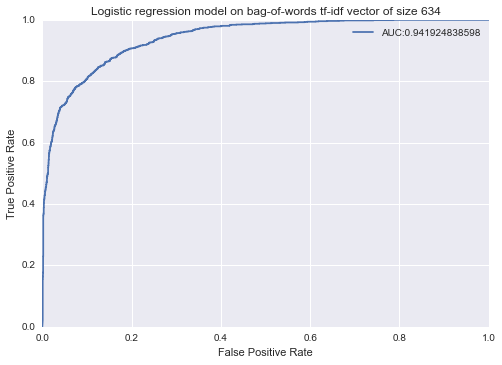

In [18]:
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
fpr, tpr, thresholds = metrics.roc_curve(
                            df['actual_label'].tolist(),
                            df['predicted_label_proba'].tolist(), 
                            pos_label=1
                        )
auc = metrics.auc(fpr, tpr)
rocdf = pd.DataFrame(np.transpose([fpr, tpr, thresholds]), columns = ['fpr','tpr','thresholds'])
rocdf.plot(x='fpr',y='tpr', label='AUC:{0}'.format(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic regression model on bag-of-words tf-idf vector of size {0}'.format(vocabulary_size))
plt.show()